In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import numpy as np
from PIL import Image

import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip /content/drive/My\ Drive/cil-road-segmentation-2020.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
Archive:  /content/drive/My Drive/cil-road-segmentation-2020.zip
  inflating: mask_to_submission.py   
  inflating: sample_submission.csv   
  inflating: submission_to_mask.py   
  inflating: test_images/test_images/test_10.png  
  inflating: test_images/test_images/test_105.png  
  inflating: test_images/test_images/test_106.png  
  inflating: test_images/test_images/test_107.png  
  inflating: test_images/test_images/test_108.png  
  inflating: test_images/

In [3]:
def np_from_files(files: list, rotate=False) -> np.ndarray:
  x = []
  for f in files:
    image = Image.open(f)
    
    image.thumbnail((224,224), Image.ANTIALIAS)

    x.append(np.asarray(image))

    if rotate:
      for deg in range(90, 271, 90):
        new_image = image.rotate(deg)
        x.append(np.asarray(new_image))

  return np.asarray(x)

def one_or_zero(v):
  func = lambda x: 1.0 if x>10 else 0.0
  return np.venp.vectorize(func)

def get_training_data(rotate=False) -> (np.ndarray, np.ndarray):
  x_files = glob.glob('training/training/images/*.png')
  y_files = glob.glob('training/training/groundtruth/*.png')

  x = np_from_files(sorted(x_files), rotate)
  y = np_from_files(sorted(y_files), rotate)
  y = (y > 42).astype(np.uint8)

  return x, y

def get_test_data() -> np.ndarray:
  x_files = glob.glob('test_images/test_images/*.png')

  x = np_from_files(sorted(x_files))

  return x

In [4]:
def show_image(image, mask):
  fig=plt.figure(figsize=(8, 8))
  
  fig.add_subplot(1,2,1)
  plt.imshow(image)
  fig.add_subplot(1,2,2)
  plt.imshow(mask)

In [5]:
def show_image_pred(image, mask, pred):
  fig=plt.figure(figsize=(8, 8))
  
  fig.add_subplot(1,3,1)
  plt.imshow(image)
  fig.add_subplot(1,3,2)
  plt.imshow(mask)
  fig.add_subplot(1,3,3)
  plt.imshow(pred)

In [6]:
imgs , gt_imgs = get_training_data(rotate=True)
x_test = get_test_data()

In [7]:
imgs.shape

(400, 224, 224, 3)

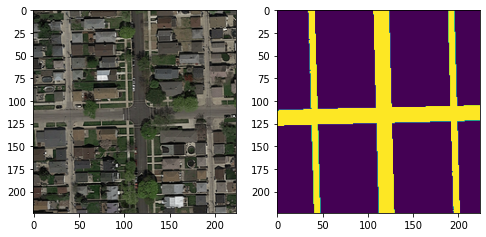

In [8]:
show_image(imgs[0], gt_imgs[0])

In [9]:
# -*- coding: utf-8 -*-

import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import re

def load_image(infilename):
    """ Load an image from disk. """
    return mpimg.imread(infilename)

def pad_image(data, padding):
    """
    Extend the canvas of an image. Mirror boundary conditions are applied.
    """
    if len(data.shape) < 3:
        # Greyscale image (ground truth)
        data = np.lib.pad(data, ((padding, padding), (padding, padding)), 'reflect')
    else:
        # RGB image
        data = np.lib.pad(data, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    return data
    
def img_crop_gt(im, w, h, stride):
    """ Crop an image into patches (this method is intended for ground truth images). """
    assert len(im.shape) == 2, 'Expected greyscale image.'
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    for i in range(0,imgheight,stride):
        for j in range(0,imgwidth,stride):
            im_patch = im[j:j+w, i:i+h]
            list_patches.append(im_patch)
    return list_patches
    
def img_crop(im, w, h, stride, padding):
    """ Crop an image into patches, taking into account mirror boundary conditions. """
    assert len(im.shape) == 3, 'Expected RGB image.'
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    im = np.lib.pad(im, ((padding, padding), (padding, padding), (0,0)), 'reflect')
    for i in range(padding,imgheight+padding,stride):
        for j in range(padding,imgwidth+padding,stride):
            im_patch = im[j-padding:j+w+padding, i-padding:i+h+padding, :]
            list_patches.append(im_patch)
    return list_patches
    
def create_patches(X, patch_size, stride, padding):
    img_patches = np.asarray([img_crop(X[i], patch_size, patch_size, stride, padding) for i in range(X.shape[0])])
    # Linearize list
    img_patches = img_patches.reshape(-1, img_patches.shape[2], img_patches.shape[3], img_patches.shape[4])
    return img_patches
    
def create_patches_gt(X, patch_size, stride):
    img_patches = np.asarray([img_crop_gt(X[i], patch_size, patch_size, stride) for i in range(X.shape[0])])
    # Linearize list
    img_patches = img_patches.reshape(-1, img_patches.shape[2], img_patches.shape[3])
    return img_patches
    
def group_patches(patches, num_images):
    return patches.reshape(num_images, -1)

def extract_img_features(filename, stride):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size, stride, padding)
    X = np.asarray([img_patches[i] for i in range(len(img_patches))])
    return X

def mask_to_submission_strings(model, image_filename):
    """ Reads a single image and outputs the strings that should go into the submission file. """
    img_number = int(re.search(r"\d+", image_filename).group(0))
    Xi = load_image(image_filename)
    Xi = Xi.reshape(1, Xi.shape[0], Xi.shape[1], Xi.shape[2])
    Zi = model.classify(Xi)
    Zi = Zi.reshape(-1)
    patch_size = 16
    nb = 0
    print("Processing " + image_filename)
    for j in range(0, Xi.shape[2], patch_size):
        for i in range(0, Xi.shape[1], patch_size):
            label = int(Zi[nb])
            nb += 1
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def generate_submission(model, submission_filename, *image_filenames):
    """ Generate a .csv containing the classification of the test set. """
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(model, fn))

In [10]:
# -*- coding: utf-8 -*-

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from keras import backend as K
from keras.regularizers import l2
from keras.layers import LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#from helpers import *

class CnnModel:
    
    def __init__(self):
        """ Construct a CNN classifier. """
        
        self.patch_size = 16
        self.window_size = 72
        self.padding = (self.window_size - self.patch_size) // 2
        self.initialize()
        
    def initialize(self):
        """ Initialize or reset this model. """
        patch_size = self.patch_size
        window_size = self.window_size
        padding = self.padding
        nb_classes = 2
        
        # Size of pooling area for max pooling
        pool_size = (2, 2)

        # Compatibility with Theano and Tensorflow ordering
        if K.common.image_dim_ordering() == 'th':
            input_shape = (3, window_size, window_size)
        else:
            input_shape = (window_size, window_size, 3)

        reg = 1e-6 # L2 regularization factor (used on weights, but not biases)

        self.model = Sequential()

        self.model.add(Convolution2D(64, 5, 5, # 64 5x5 filters
                                border_mode='same',
                                input_shape=input_shape
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Convolution2D(128, 3, 3, # 128 3x3 filters
                                border_mode='same'
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                border_mode='same'
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Convolution2D(256, 3, 3, # 256 3x3 filters
                                border_mode='same'
                               ))
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(MaxPooling2D(pool_size=pool_size, border_mode='same'))
        self.model.add(Dropout(0.25))

        self.model.add(Flatten())
        self.model.summary()
        self.model.add(Dense(128, W_regularizer=l2(reg)
                            )) # Fully connected layer (128 neurons)
        self.model.add(LeakyReLU(alpha=0.1))
        self.model.add(Dropout(0.5))

        self.model.add(Dense(nb_classes, W_regularizer=l2(reg)
                            ))
        #self.model.add(Activation('softmax')) # Not needed since we use logits
        
    
    def train(self, Y, X):
        """
        Train this model with the given dataset.
        """
        
        patch_size = self.patch_size
        window_size = self.window_size
        padding = self.padding
        
        print('Training set shape: ', X.shape)
        samples_per_epoch = X.shape[0]*X.shape[1]*X.shape[2]//256 # Arbitrary value
        
        # Pad training set images (by appling mirror boundary conditions)
        X_new = np.empty((X.shape[0],
                         X.shape[1] + 2*padding, X.shape[2] + 2*padding,
                         X.shape[3]))
        Y_new = np.empty((Y.shape[0],
                         Y.shape[1] + 2*padding, Y.shape[2] + 2*padding))
        for i in range(X.shape[0]):
            X_new[i] = pad_image(X[i], padding)
            Y_new[i] = pad_image(Y[i], padding)
        X = X_new
        Y = Y_new
            
        batch_size = 125
        nb_classes = 2
        nb_epoch = 1

        def softmax_categorical_crossentropy(y_true, y_pred):
            """
            Uses categorical cross-entropy from logits in order to improve numerical stability.
            This is especially useful for TensorFlow (less useful for Theano).
            """
            return K.categorical_crossentropy(y_pred, y_true, from_logits=True)

        opt = Adam(lr=0.001) # Adam optimizer with default initial learning rate
        self.model.compile(loss=softmax_categorical_crossentropy,
                      optimizer=opt,
                      metrics=['accuracy'])

        np.random.seed(3) # Ensure determinism
        
        def generate_minibatch():
            """
            Procedure for real-time minibatch creation and image augmentation.
            This runs in a parallel thread while the model is being trained.
            """
            while 1:
                # Generate one minibatch
                X_batch = np.empty((batch_size, window_size, window_size, 3))
                Y_batch = np.empty((batch_size, 2))
                for i in range(batch_size):
                    # Select a random image
                    idx = np.random.choice(X.shape[0])
                    shape = X[idx].shape
                    
                    # Sample a random window from the image
                    center = np.random.randint(window_size//2, shape[0] - window_size//2, 2)
                    sub_image = X[idx][center[0]-window_size//2:center[0]+window_size//2,
                                       center[1]-window_size//2:center[1]+window_size//2]
                    gt_sub_image = Y[idx][center[0]-patch_size//2:center[0]+patch_size//2,
                                          center[1]-patch_size//2:center[1]+patch_size//2]
                    
                    # The label does not depend on the image rotation/flip (provided that the rotation is in steps of 90°)
                    threshold = 0.25
                    label = (np.array([np.mean(gt_sub_image)]) > threshold) * 1
                    
                    # Image augmentation
                    # Random flip
                    if np.random.choice(2) == 0:
                        # Flip vertically
                        sub_image = np.flipud(sub_image)
                    if np.random.choice(2) == 0:
                        # Flip horizontally
                        sub_image = np.fliplr(sub_image)
                    
                    # Random rotation in steps of 90°
                    num_rot = np.random.choice(4)
                    sub_image = np.rot90(sub_image, num_rot)

                    label = np_utils.to_categorical(label, nb_classes)
                    X_batch[i] = sub_image
                    Y_batch[i] = label
                
                if K.common.image_dim_ordering() == 'th':
                    X_batch = np.rollaxis(X_batch, 3, 1)
                    
                yield (X_batch, Y_batch)

        # This callback reduces the learning rate when the training accuracy does not improve any more
        lr_callback = ReduceLROnPlateau(monitor='acc', factor=0.5, patience=5,
                                        verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)
        
        # Stops the training process upon convergence
        stop_callback = EarlyStopping(monitor='acc', min_delta=0.0001, patience=11, verbose=1, mode='auto')
        
        try:
            self.model.fit_generator(generate_minibatch(),
                            samples_per_epoch=samples_per_epoch,
                            nb_epoch=nb_epoch,
                            verbose=1,
                            callbacks=[lr_callback, stop_callback])
        except KeyboardInterrupt:
            # Do not throw away the model in case the user stops the training process
            pass

        print('Training completed')
        
    def save(self, filename):
        """ Save the weights of this model. """
        self.model.save_weights(filename)
        
    def load(self, filename):
        """ Load the weights for this model from a file. """
        self.model.load_weights(filename)
        
    def classify(self, X):
        """
        Classify an unseen set of samples.
        This method must be called after "train".
        Returns a list of predictions.
        """
        # Subdivide the images into blocks
        img_patches = create_patches(X, self.patch_size, 16, self.padding)
        
        if K.common.image_dim_ordering() == 'th':
            img_patches = np.rollaxis(img_patches, 3, 1)
        
        # Run prediction
        Z = self.model.predict(img_patches)
        Z = (Z[:,0] < Z[:,1]) * 1
        
        # Regroup patches into images
        return group_patches(Z, X.shape[0])

Using TensorFlow backend.


In [11]:
model = CnnModel()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(72, 72, 3..., padding="same")`


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 36, 36, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:63: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:67: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3

In [ ]:
np.random.seed(1) # Ensure reproducibility

model.model.summary()
model.train(gt_imgs, imgs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 72, 64)        4864      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 36, 36, 128)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)      

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:186: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=78400, epochs=1)`


Epoch 1/1
 1494/78400 [..............................] - ETA: 1:51:20 - loss: -1622392532235558584320.0000 - accuracy: 0.6612

In [ ]:
# Save weights to disk
model.save('saved_weights.h5')